In [1295]:
import pandas as pd # type:ignore
import numpy as np # type:ignore
import matplotlib.pyplot as plt # type:ignore
import seaborn as sns # type:ignore
from sklearn.datasets import make_blobs # type:ignore
from scipy.stats import multivariate_normal # type:ignore
from sklearn.metrics import confusion_matrix,classification_report # type:ignore
import warnings # type:ignore
from scipy.optimize import linear_sum_assignment # type:ignore
from matplotlib.lines import Line2D # type:ignore
from sklearn.preprocessing import StandardScaler # type:ignore
from sklearn.decomposition import PCA # type:ignore
from sklearn.manifold import TSNE # type:ignore
import umap # type:ignore
from sklearn.cluster import KMeans,DBSCAN # type:ignore
from sklearn.neighbors import NearestNeighbors # type:ignore
warnings.filterwarnings("ignore", category=UserWarning)

# data

In [1296]:
np.random.seed(42)

In [1297]:
def generate_correlated_clusters(n_samples,n_features,n_clusters,correlation=0.5,random_state=None):

    np.random.seed(random_state)

    X_blobs,y_blobs = make_blobs(n_samples=n_samples,centers=n_clusters,n_features=n_features,random_state=random_state)

    centers = np.array([X_blobs[y_blobs == i].mean(axis=0) for i in range(n_clusters)])

    X,y = [],[]

    for i,center in enumerate(centers):
    
        cov_matrix = np.full((n_features,n_features),correlation)  
        np.fill_diagonal(cov_matrix,1)  

        cluster_samples = np.random.multivariate_normal(mean=center,cov=cov_matrix,size=n_samples // n_clusters)

        X.append(cluster_samples)
        y.append(np.full(n_samples // n_clusters, i)) 

    X = np.vstack(X)
    y = np.hstack(y)

    return X, y

In [1298]:
X, y = generate_correlated_clusters(n_samples=1000,n_features=5,n_clusters=2,correlation=0.6,random_state=42)
X = X + np.random.normal(scale=2,size=X.shape) 

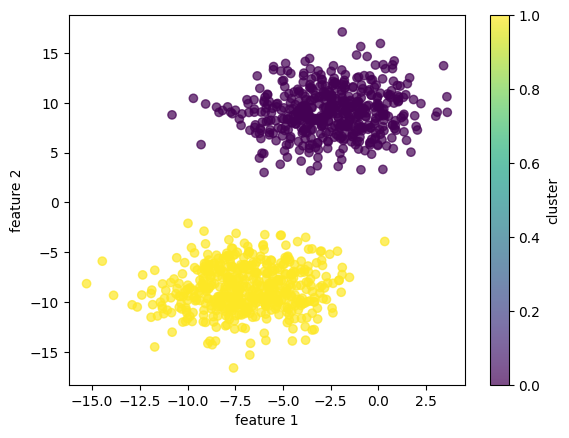

In [1299]:
plt.scatter(X[:,0],X[:,1],c=y,cmap='viridis',alpha=0.7)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.colorbar(label="cluster")
plt.show()

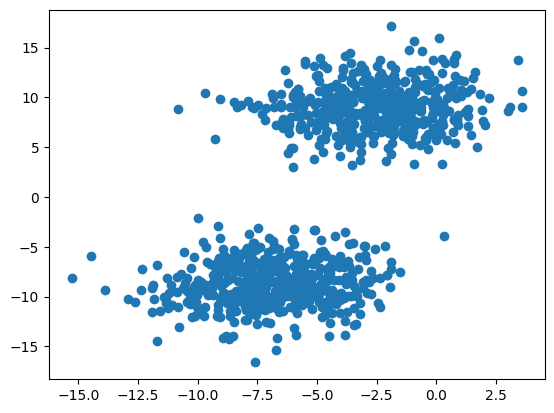

In [1300]:
plt.scatter(X[:,0],X[:,1])
plt.show()

In [1301]:
corr_dataset = pd.DataFrame(X) 

In [1302]:
corr_dataset.columns = [f"vab_{col+1}" for col in corr_dataset.columns]

In [1303]:
corr_dataset['target'] = y

In [1304]:
corr_dataset

vab_1      vab_2     vab_3     vab_4     vab_5  target
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0
..        ...        ...       ...       ...       ...     ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1

[1000 rows x 6 columns]

In [1305]:
# sns.pairplot(corr_dataset)

## correlation matrix

In [1306]:
corr_dataset.iloc[:,:-1].corr()

vab_1     vab_2     vab_3     vab_4     vab_5
vab_1  1.000000  0.683826 -0.302348  0.069323 -0.627136
vab_2  0.683826  1.000000 -0.480222 -0.029255 -0.902210
vab_3 -0.302348 -0.480222  1.000000  0.120638  0.512079
vab_4  0.069323 -0.029255  0.120638  1.000000  0.086192
vab_5 -0.627136 -0.902210  0.512079  0.086192  1.000000

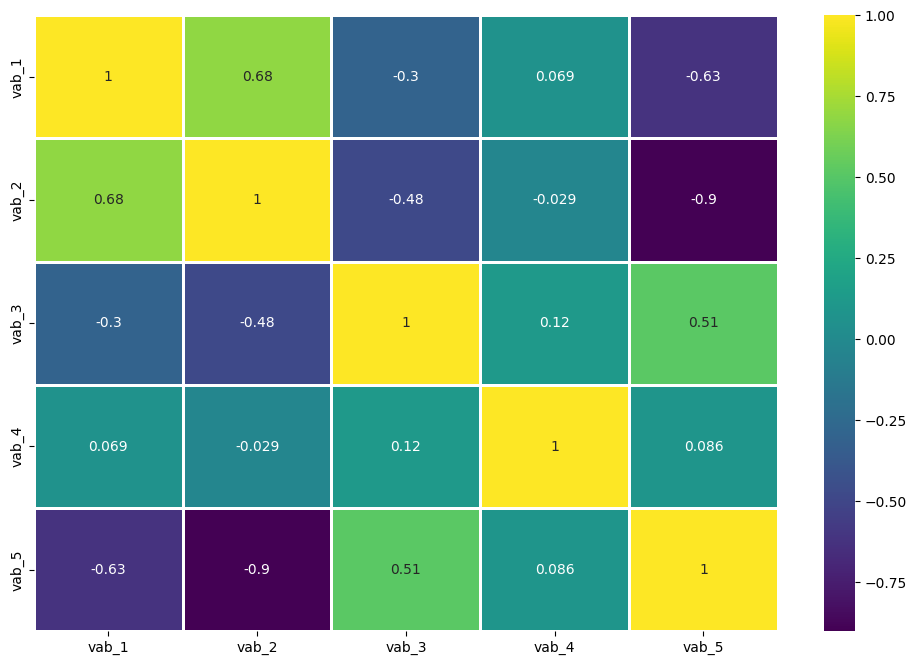

In [1307]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_dataset.iloc[:,:-1].corr(),cmap='viridis',annot=True,linewidths=1)
plt.show()

## data standardization

In [1308]:
X_values = corr_dataset.iloc[:,:-1].values

In [1309]:
y_values = corr_dataset.iloc[:,-1].values

In [1310]:
scaler = StandardScaler()

In [1311]:
X_values = scaler.fit_transform(X_values)

In [1312]:
np.mean(X_values),np.std(X_values)

(-1.0516032489249483e-16, 1.0000000000000002)

In [1313]:
pd.DataFrame(X_values)

0         1         2         3         4
0    0.281827  0.921082 -2.075146 -0.688810 -0.751406
1    0.242318  1.169621  0.094110 -0.706915 -0.983584
2    1.731838  1.066540 -0.383145  0.047807 -0.611364
3    0.344975  0.523236  1.231978  0.389571 -0.532865
4    0.245409  0.596812 -1.053459 -1.820045 -0.266412
..        ...       ...       ...       ...       ...
995 -0.408273 -0.500613 -0.146418 -0.607436  0.656066
996 -0.480308 -1.017496  1.381031  0.650101  0.621154
997 -1.371234 -1.206662 -1.035498 -1.283070  0.232416
998  0.887442 -0.738188  1.505107 -0.600174  1.614013
999  0.282610 -1.388152  0.205795 -0.326403  1.229651

[1000 rows x 5 columns]

<Axes: ylabel='Density'>

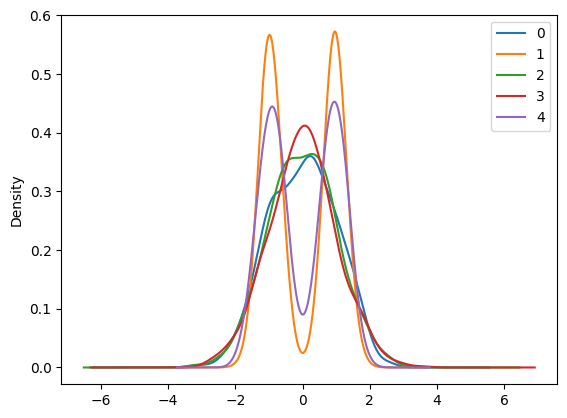

In [1314]:
pd.DataFrame(X_values).plot(kind='density')

## pca 

In [1315]:
pca_general = PCA()

In [1316]:
pca_general.fit(X_values)

PCA()

In [1317]:
explained_variance = pca_general.explained_variance_ratio_

In [1318]:
explained_variance

array([0.56067428, 0.21074422, 0.13479115, 0.07525016, 0.01854019])

In [1319]:
eigenvalues = pca_general.explained_variance_

In [1320]:
pd.DataFrame(eigenvalues)

0
0  2.806178
1  1.054776
2  0.674630
3  0.376627
4  0.092794

In [1321]:
eigenvectors = pca_general.components_

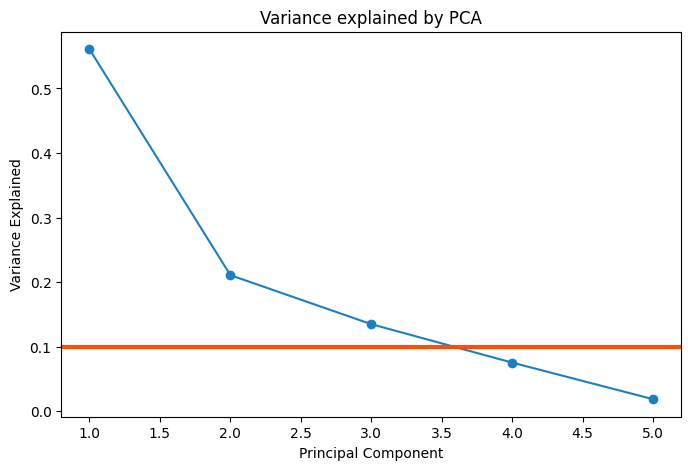

In [1322]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='#1B80BF')
plt.axhline(y=0.1, color='#FC4E07', linewidth=3)
plt.title('Variance explained by PCA')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [1323]:
pca = PCA(n_components=2)

In [1324]:
principal_components = pca.fit_transform(X_values)

In [1325]:
pd.DataFrame(principal_components).head(8)

0         1
0  1.906285 -1.078216
1  1.312628 -0.514422
2  1.900628  0.439561
3  0.255972  0.800907
4  1.088573 -1.873830
5  0.972985  0.852323
6  1.075327  0.986642
7  2.585987  2.832113

In [1326]:
principal_df = pd.DataFrame(data = principal_components,columns = ['principal component 1','principal component 2'])

In [1327]:
final_df = pd.concat([principal_df,corr_dataset[['target']]],axis = 1)

In [1328]:
final_df

principal component 1  principal component 2  target
0                 1.906285              -1.078216       0
1                 1.312628              -0.514422       0
2                 1.900628               0.439561       0
3                 0.255972               0.800907       0
4                 1.088573              -1.873830       0
..                     ...                    ...     ...
995              -0.754859              -0.725278       1
996              -1.709194               0.797723       1
997              -0.992248              -1.886579       1
998              -1.456027               0.057742       1
999              -1.397181              -0.237439       1

[1000 rows x 3 columns]

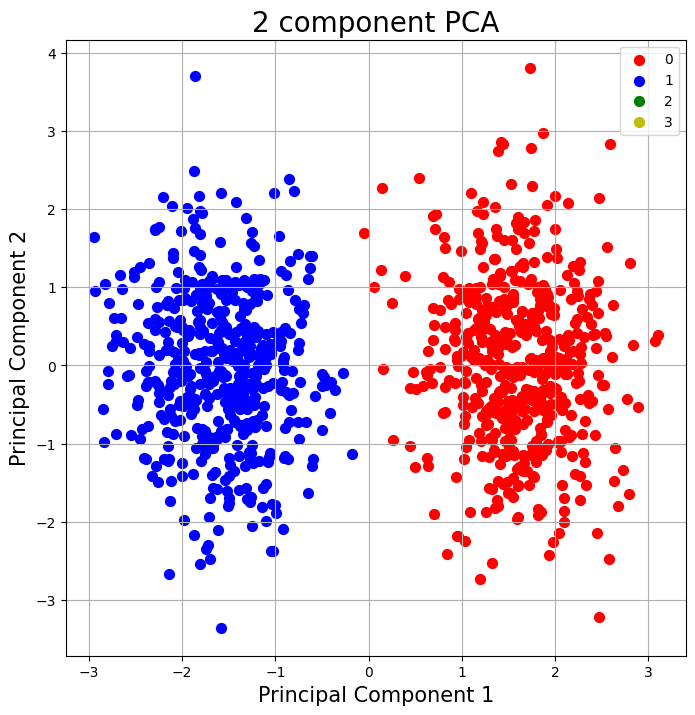

In [1329]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1',fontsize = 15)
ax.set_ylabel('Principal Component 2',fontsize = 15)
ax.set_title('2 component PCA',fontsize = 20)

targets = [0,1,2,3]
colors = ['r','b','g','y']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               ,final_df.loc[indicesToKeep, 'principal component 2']
               ,c = color
               ,s = 50)
ax.legend(targets)
ax.grid()

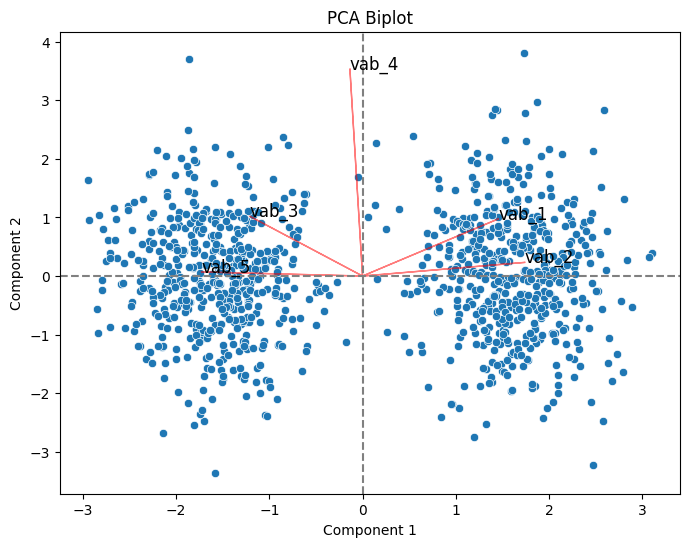

In [1330]:
scores = pca.transform(X_values)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1])
for i, col in enumerate(corr_dataset.iloc[:,:-1].columns):
    plt.arrow(0, 0, eigenvectors[0, i] * max(scores[:, 0]), eigenvectors[1, i] * max(scores[:, 1]), color='r', alpha=0.5)
    plt.text(eigenvectors[0, i] * max(scores[:, 0]), eigenvectors[1, i] * max(scores[:, 1]), col, fontsize=12)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Biplot')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

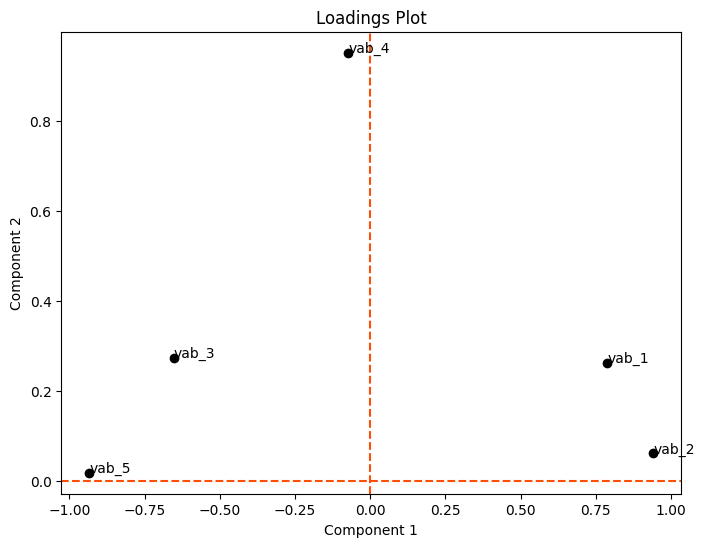

In [1331]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 0], loadings[:, 1], color='black')
for i, txt in enumerate(corr_dataset.iloc[:,:-1].columns):
    plt.text(loadings[i, 0], loadings[i, 1], txt, fontsize=10)
plt.axhline(0, color='#FC4E07', linestyle='--')
plt.axvline(0, color='#FC4E07', linestyle='--')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Loadings Plot')
plt.show()

In [1332]:
scores_pca = pca.transform(X_values)

In [1333]:
pd.DataFrame(scores_pca).head()

0         1
0  1.906285 -1.078216
1  1.312628 -0.514422
2  1.900628  0.439561
3  0.255972  0.800907
4  1.088573 -1.873830

## t-SNE

In [1334]:
tsne = TSNE(n_components=2,random_state=42)

In [1335]:
X_tsne = tsne.fit_transform(X_values)

In [1336]:
tsne_data = pd.concat([pd.DataFrame(X_tsne,columns=('dim_1','dim_2')),corr_dataset['target']],axis=1)

In [1337]:
tsne_data

dim_1      dim_2  target
0    48.380333  -0.465913       0
1    21.704966  -2.095075       0
2    29.185528  10.778828       0
3    16.092567  12.430140       0
4    30.275354 -12.503187       0
..         ...        ...     ...
995 -42.570881  -3.983198       1
996 -17.712461 -10.342561       1
997 -46.014996  -0.476004       1
998 -21.810297 -20.420576       1
999 -31.154287   4.463726       1

[1000 rows x 3 columns]

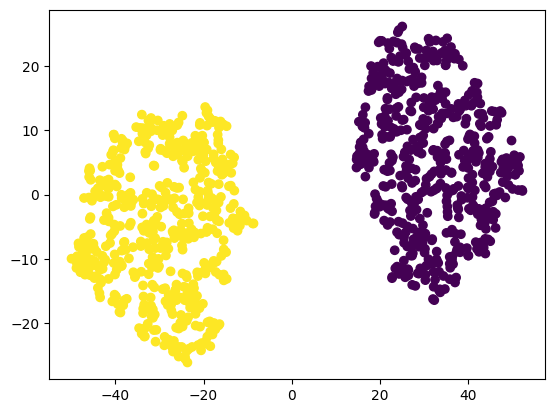

In [1338]:
plt.scatter(x=tsne_data['dim_1'],y=tsne_data['dim_2'],c=tsne_data['target'])
plt.show()

In [1339]:
tsne.kl_divergence_

0.8948878049850464

## UMAP

In [1340]:
umap = umap.UMAP(random_state=42)

In [1341]:
X_umap = umap.fit_transform(X_values)

In [1342]:
UMAP_data = pd.concat([pd.DataFrame(X_umap,columns=('dim_1','dim_2')),corr_dataset['target']],axis=1)

In [1343]:
UMAP_data

dim_1     dim_2  target
0    11.772939  4.175226       0
1    13.145459  7.250788       0
2    14.045796  5.949106       0
3    15.024148  7.337059       0
4    11.051543  6.571222       0
..         ...       ...     ...
995  -2.263630  7.659494       1
996  -0.108237  5.139722       1
997  -3.253379  7.801752       1
998  -0.697003  4.150897       1
999  -1.221844  5.074560       1

[1000 rows x 3 columns]

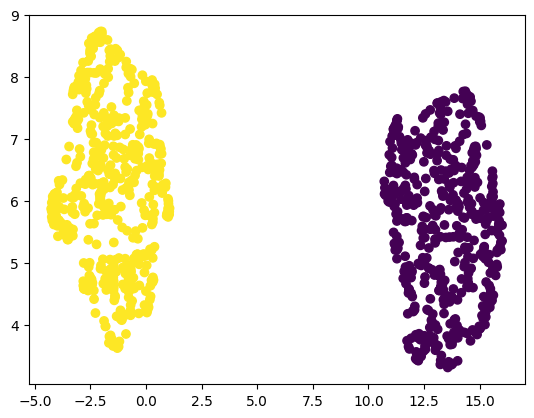

In [1344]:
plt.scatter(UMAP_data['dim_1'],UMAP_data['dim_2'],c=UMAP_data['target'])
plt.show()

## k-means 

In [1345]:
kmeans = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [1346]:
kmeans.fit(X_values)

KMeans(n_clusters=2, random_state=42)

In [1347]:
df_kmeans = corr_dataset.copy()

In [1348]:
df_kmeans['k_means'] = kmeans.labels_

In [1349]:
df_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  k_means
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0        0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0        0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0        0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0        0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0        0
..        ...        ...       ...       ...       ...     ...      ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1        1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1        1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1        1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1        1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1        1

[1000 rows x 7 columns]

In [1350]:
y_true = df_kmeans['target'].values  
y_kmeans = df_kmeans['k_means'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_kmeans['k_means'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_kmeans['k_means'] == y_true))

accuracy before: 1.0
accuracy after: 1.0


In [1351]:
df_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  k_means
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0        0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0        0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0        0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0        0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0        0
..        ...        ...       ...       ...       ...     ...      ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1        1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1        1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1        1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1        1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1        1

[1000 rows x 7 columns]

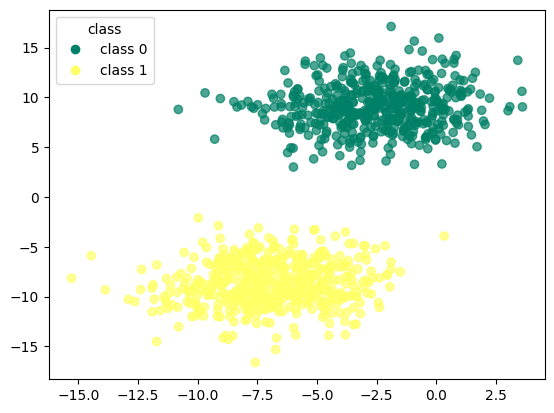

In [1352]:
scatter = plt.scatter(df_kmeans.iloc[:, 0], df_kmeans.iloc[:, 1], 
                      c=df_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

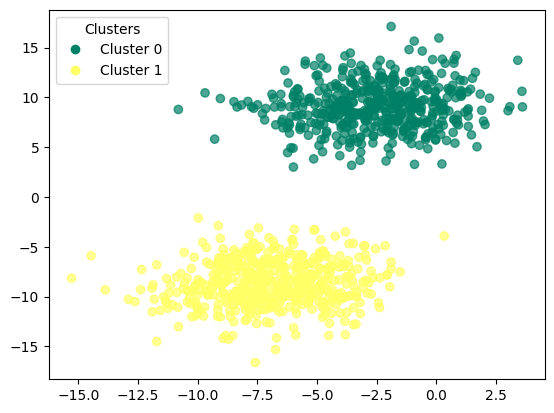

In [1353]:
scatter = plt.scatter(df_kmeans.iloc[:, 0], df_kmeans.iloc[:, 1], 
                      c=df_kmeans['k_means'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_kmeans['k_means'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [1354]:
kmeans.cluster_centers_

array([[ 0.68798545,  0.96911856, -0.51188603, -0.05535486, -0.93519892],
       [-0.68798545, -0.96911856,  0.51188603,  0.05535486,  0.93519892]])

In [1355]:
print(confusion_matrix(df_kmeans['target'],df_kmeans['k_means']))

[[500   0]
 [  0 500]]


In [1356]:
print(classification_report(df_kmeans['target'],df_kmeans['k_means']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



### k-means with pca

In [1357]:
kmeans_pca = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [1358]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=2, random_state=42)

In [1359]:
df_pca_kmeans = corr_dataset.copy()

In [1360]:
df_pca_kmeans["kmeans_pca"] = kmeans_pca.labels_

In [1361]:
df_pca_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  kmeans_pca
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0           0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0           0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0           0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0           0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0           0
..        ...        ...       ...       ...       ...     ...         ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1           1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1           1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1           1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1           1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1           1

[1000 rows x 7 columns]

In [1362]:
y_true = df_pca_kmeans['target'].values  
y_kmeans = df_pca_kmeans['kmeans_pca'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_pca_kmeans['kmeans_pca'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_pca_kmeans['kmeans_pca'] == y_true))

accuracy before: 0.999
accuracy after: 0.999


In [1363]:
df_pca_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  kmeans_pca
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0           0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0           0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0           0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0           0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0           0
..        ...        ...       ...       ...       ...     ...         ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1           1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1           1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1           1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1           1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1           1

[1000 rows x 7 columns]

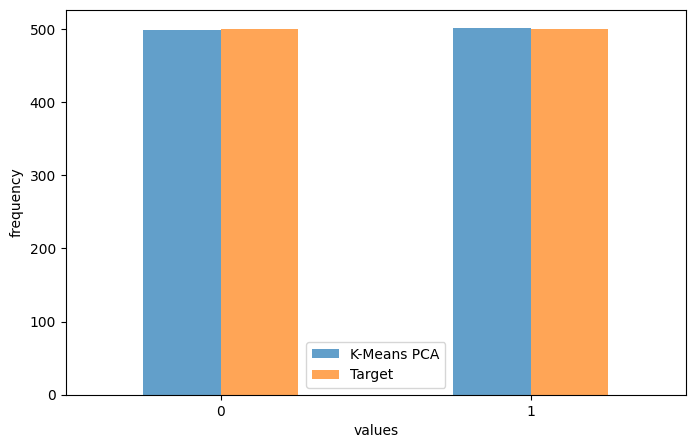

In [1364]:
counts_kmeans = df_pca_kmeans['kmeans_pca'].value_counts().sort_index()
counts_target = df_pca_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means PCA': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means PCA", "Target"])
plt.xticks(rotation=0)  
plt.show()


In [1365]:
print(confusion_matrix(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

[[499   1]
 [  0 500]]


In [1366]:
print(classification_report(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



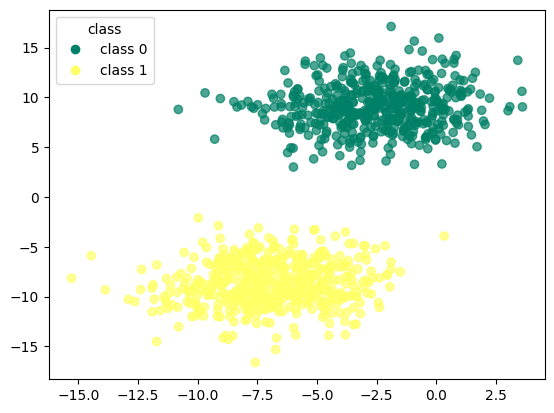

In [1367]:
scatter = plt.scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                      c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

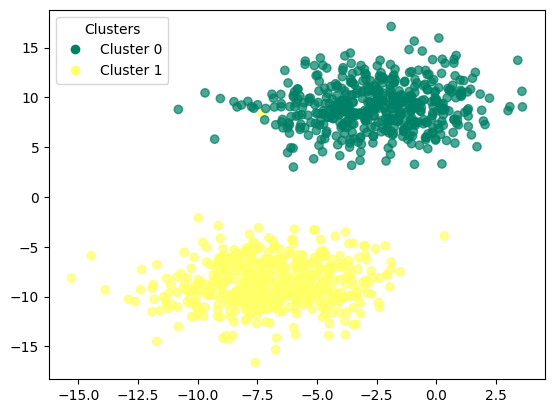

In [1368]:
scatter = plt.scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                      c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

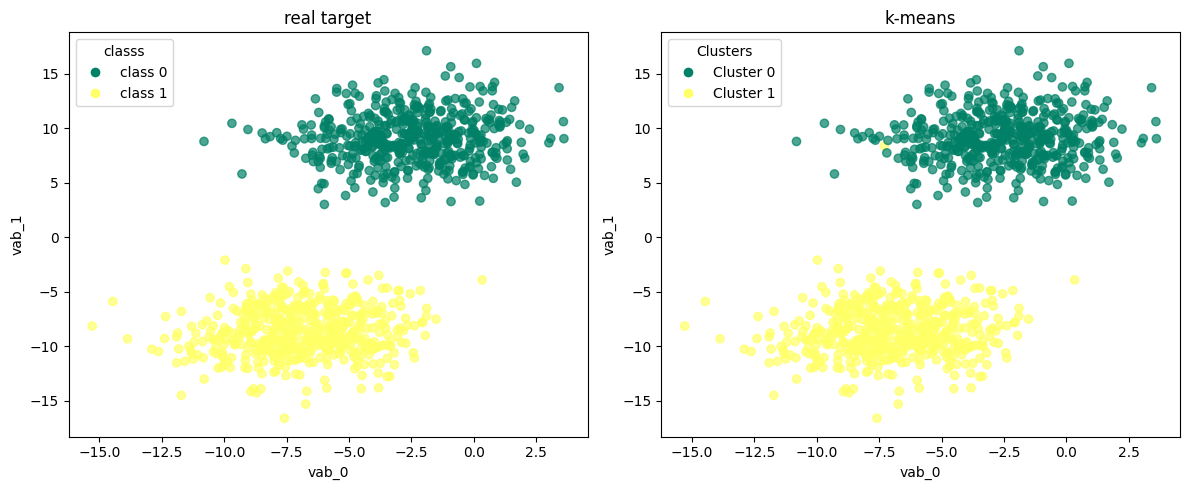

In [1369]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                           c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                           c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

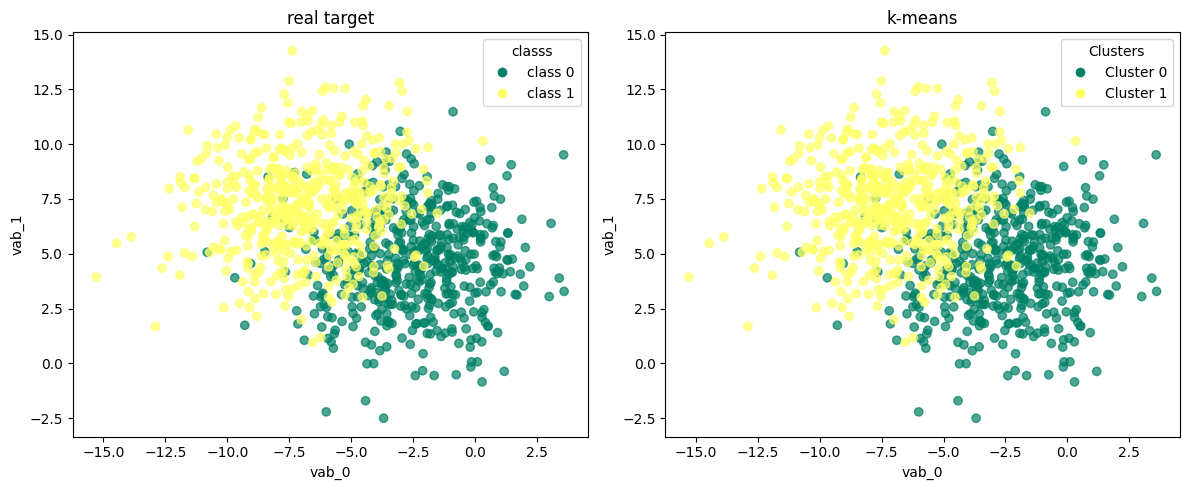

In [1370]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 2], 
                           c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 2], 
                           c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

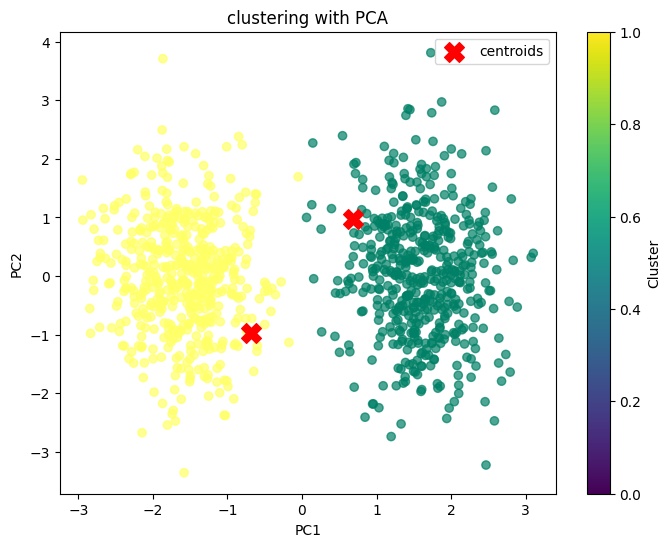

In [1371]:
plt.figure(figsize=(8, 6))
plt.scatter(final_df['principal component 1'], final_df['principal component 2'] , c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='X', s=200, label='centroids')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('clustering with PCA')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

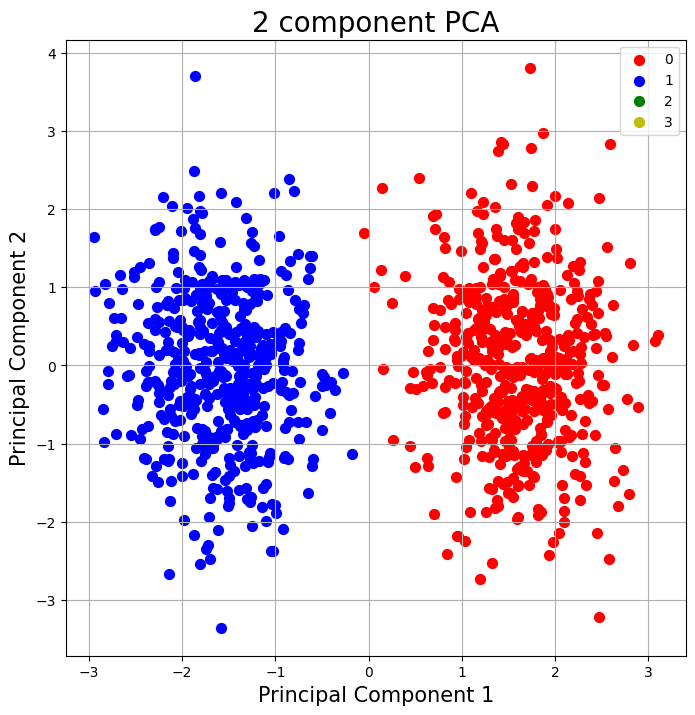

In [1372]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1',fontsize = 15)
ax.set_ylabel('Principal Component 2',fontsize = 15)
ax.set_title('2 component PCA',fontsize = 20)

targets = [0,1,2,3]
colors = ['r','b','g','y']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               ,final_df.loc[indicesToKeep, 'principal component 2']
               ,c = color
               ,s = 50)
ax.legend(targets)
ax.grid()

### k-means with t-SNE

In [1373]:
kmeans_tsne = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [1374]:
kmeans_tsne.fit(X_tsne)

KMeans(n_clusters=2, random_state=42)

In [1375]:
df_tsne_kmeans = corr_dataset.copy()

In [1376]:
df_tsne_kmeans['kmeans_tsne'] = kmeans_tsne.labels_

In [1377]:
df_tsne_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  kmeans_tsne
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0            0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0            0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0            0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0            0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0            0
..        ...        ...       ...       ...       ...     ...          ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1            1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1            1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1            1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1            1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1            1

[1000 rows x 7 columns]

In [1378]:
y_true = df_tsne_kmeans['target'].values  
y_kmeans = df_tsne_kmeans['kmeans_tsne'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_tsne_kmeans['kmeans_tsne'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_tsne_kmeans['kmeans_tsne'] == y_true))

accuracy before: 1.0
accuracy after: 1.0


In [1379]:
df_tsne_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  kmeans_tsne
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0            0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0            0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0            0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0            0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0            0
..        ...        ...       ...       ...       ...     ...          ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1            1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1            1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1            1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1            1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1            1

[1000 rows x 7 columns]

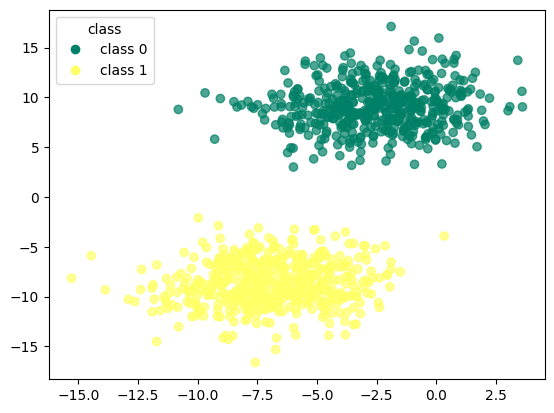

In [1380]:
scatter = plt.scatter(df_tsne_kmeans.iloc[:, 0], df_tsne_kmeans.iloc[:, 1], 
                      c=df_tsne_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

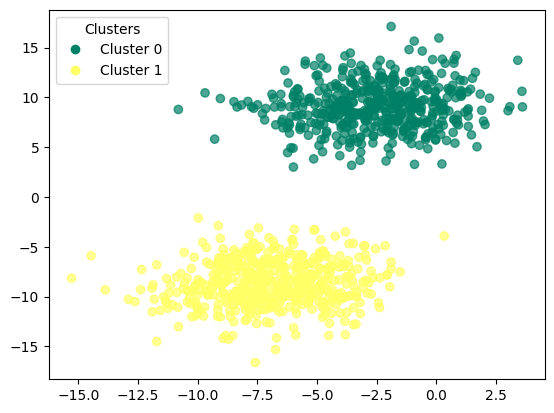

In [1381]:
scatter = plt.scatter(df_tsne_kmeans.iloc[:, 0], df_tsne_kmeans.iloc[:, 1], 
                      c=df_tsne_kmeans['kmeans_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_kmeans['kmeans_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

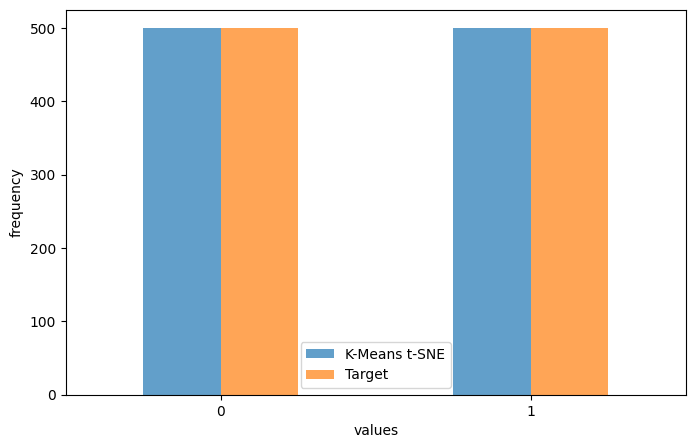

In [1382]:
counts_kmeans = df_tsne_kmeans['kmeans_tsne'].value_counts().sort_index()
counts_target = df_tsne_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means t-SNE': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means t-SNE", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [1383]:
print(confusion_matrix(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne']))

[[500   0]
 [  0 500]]


In [1384]:
print(classification_report(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



### k-means with UMAP

In [1385]:
kmeans_UMAP = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [1386]:
kmeans_UMAP.fit(X_umap)

KMeans(n_clusters=2, random_state=42)

In [1387]:
df_UMAP_kmeans = corr_dataset.copy()

In [1388]:
df_UMAP_kmeans['kmeans_UMAP'] = kmeans_UMAP.labels_

In [1389]:
df_UMAP_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  kmeans_UMAP
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0            0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0            0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0            0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0            0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0            0
..        ...        ...       ...       ...       ...     ...          ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1            1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1            1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1            1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1            1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1            1

[1000 rows x 7 columns]

In [1390]:
y_true = df_UMAP_kmeans['target'].values  
y_kmeans = df_UMAP_kmeans['kmeans_UMAP'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_UMAP_kmeans['kmeans_UMAP'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_UMAP_kmeans['kmeans_UMAP'] == y_true))

accuracy before: 1.0
accuracy after: 1.0


In [1391]:
df_UMAP_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  kmeans_UMAP
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0            0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0            0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0            0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0            0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0            0
..        ...        ...       ...       ...       ...     ...          ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1            1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1            1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1            1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1            1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1            1

[1000 rows x 7 columns]

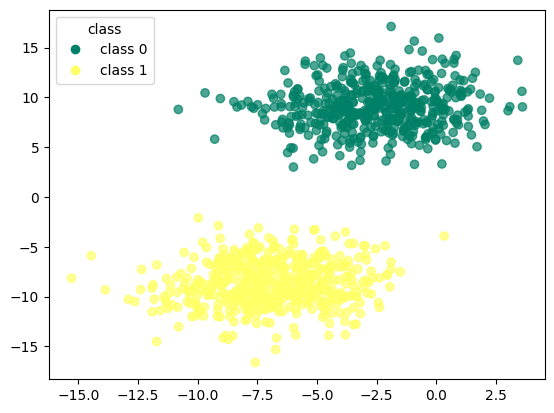

In [1392]:
scatter = plt.scatter(df_UMAP_kmeans.iloc[:, 0], df_UMAP_kmeans.iloc[:, 1], 
                      c=df_UMAP_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_UMAP_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

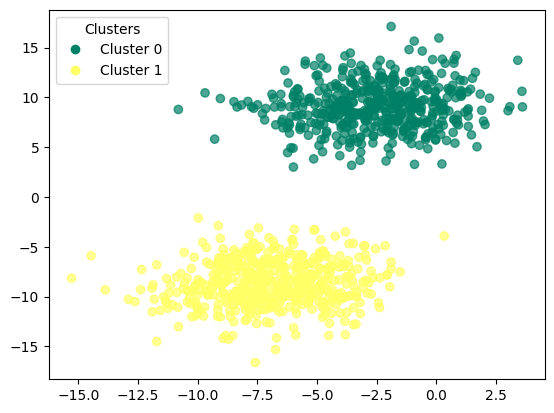

In [1393]:
scatter = plt.scatter(df_UMAP_kmeans.iloc[:, 0], df_UMAP_kmeans.iloc[:, 1], 
                      c=df_UMAP_kmeans['kmeans_UMAP'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_UMAP_kmeans['kmeans_UMAP'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

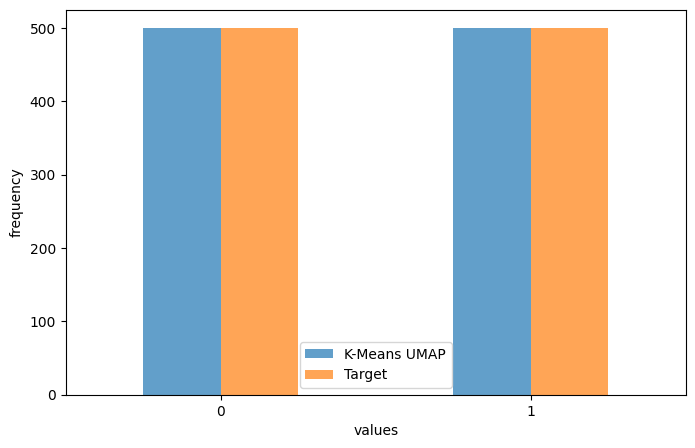

In [1394]:
counts_kmeans = df_UMAP_kmeans['kmeans_UMAP'].value_counts().sort_index()
counts_target = df_UMAP_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means UMAP': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means UMAP", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [1395]:
print(confusion_matrix(df_UMAP_kmeans['target'],df_UMAP_kmeans['kmeans_UMAP']))

[[500   0]
 [  0 500]]


In [1396]:
print(classification_report(df_UMAP_kmeans['target'],df_UMAP_kmeans['kmeans_UMAP'])) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



## trimmed k-means

In [1397]:
def trimmed_clustering(X,n_clusters,trim_fraction=0.1):

    kmeans = KMeans(n_clusters=n_clusters,random_state=42).fit(X)
    distances = np.min(kmeans.transform(X),axis=1)
    
    trim_threshold = np.percentile(distances,100 * (1 - trim_fraction))
    trimmed_X = X[distances < trim_threshold]
    trimmed_indices = np.where(distances < trim_threshold)[0]
    trimmed_kmeans = KMeans(n_clusters=n_clusters,random_state=42).fit(trimmed_X)
    
    return trimmed_kmeans,trimmed_indices

In [1398]:
trimmed_kmeans,trimmmed_indces = trimmed_clustering(X_values,n_clusters=2,trim_fraction=0.1)

In [1399]:
trimmed_kmeans

KMeans(n_clusters=2, random_state=42)

In [1400]:
df_trim_kmeans = corr_dataset.copy()

In [1401]:
df_trim_kmeans = df_trim_kmeans.iloc[trimmmed_indces]  

In [1402]:
df_trim_kmeans['trim_kmeans'] = trimmed_kmeans.labels_

In [1403]:
df_trim_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  trim_kmeans
0    -3.836390   8.639241  0.577657  0.290482 -5.854879       0            0
1    -3.963108  10.911483  6.195401  0.249843 -7.251451       0            0
2     0.814275   9.969076  4.959448  1.943864 -5.012513       0            0
3    -3.633853   5.001985  9.142150  2.710974 -4.540339       0            0
4    -3.953195   5.674644  3.223531 -2.248645 -2.937601       0            0
..         ...        ...       ...       ...       ...     ...          ...
994 -10.010557  -9.847225  7.192476  2.631717  6.903013       1            1
995  -6.049769  -4.358451  5.572504  0.473130  2.611179       1            1
996  -6.280810  -9.083992  9.528153  3.295749  2.401180       1            1
998  -1.893983  -6.530449  9.849472  0.489431  8.373307       1            1
999  -3.833880 -12.472677  6.484633  1.103926  6.061338       1            1

[900 rows x 7 columns]

In [1404]:
y_true = df_trim_kmeans['target'].values  
y_kmeans = df_trim_kmeans['trim_kmeans'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_trim_kmeans['trim_kmeans'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_trim_kmeans['trim_kmeans'] == y_true))

accuracy before: 1.0
accuracy after: 1.0


In [1405]:
df_trim_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  trim_kmeans
0    -3.836390   8.639241  0.577657  0.290482 -5.854879       0            0
1    -3.963108  10.911483  6.195401  0.249843 -7.251451       0            0
2     0.814275   9.969076  4.959448  1.943864 -5.012513       0            0
3    -3.633853   5.001985  9.142150  2.710974 -4.540339       0            0
4    -3.953195   5.674644  3.223531 -2.248645 -2.937601       0            0
..         ...        ...       ...       ...       ...     ...          ...
994 -10.010557  -9.847225  7.192476  2.631717  6.903013       1            1
995  -6.049769  -4.358451  5.572504  0.473130  2.611179       1            1
996  -6.280810  -9.083992  9.528153  3.295749  2.401180       1            1
998  -1.893983  -6.530449  9.849472  0.489431  8.373307       1            1
999  -3.833880 -12.472677  6.484633  1.103926  6.061338       1            1

[900 rows x 7 columns]

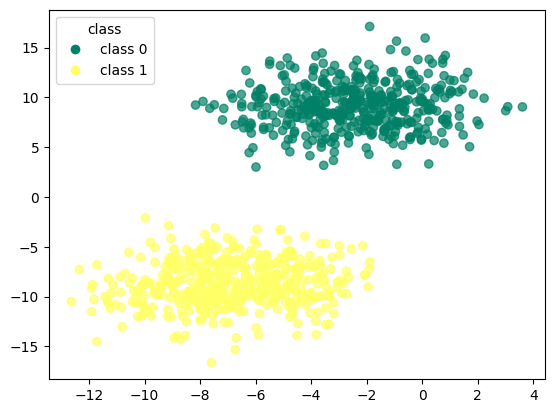

In [1406]:
scatter = plt.scatter(df_trim_kmeans.iloc[:, 0], df_trim_kmeans.iloc[:, 1], 
                      c=df_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

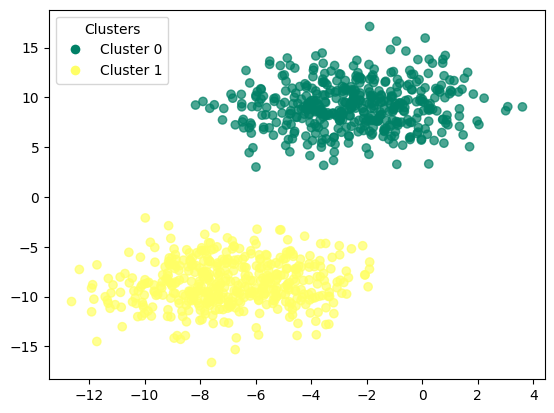

In [1407]:
scatter = plt.scatter(df_trim_kmeans.iloc[:, 0], df_trim_kmeans.iloc[:, 1], 
                      c=df_trim_kmeans['trim_kmeans'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_trim_kmeans['trim_kmeans'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [1408]:
print(confusion_matrix(df_trim_kmeans['target'],df_trim_kmeans['trim_kmeans']))

[[444   0]
 [  0 456]]


In [1409]:
print(classification_report(df_trim_kmeans['target'],df_trim_kmeans['trim_kmeans']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      1.00      1.00       456

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



### trimmed k-means with pca

In [1410]:
trim_kmeans_pca,trimmmed_indices = trimmed_clustering(scores_pca,n_clusters=2,trim_fraction=0.1)

In [1411]:
trim_kmeans_pca

KMeans(n_clusters=2, random_state=42)

In [1412]:
df_pca_trim_kmeans = corr_dataset.copy()

In [1413]:
df_pca_trim_kmeans = df_pca_trim_kmeans.iloc[trimmmed_indces]  

In [1414]:
df_pca_trim_kmeans["trim_kmeans_pca"] = trim_kmeans_pca.labels_

In [1415]:
df_pca_trim_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  \
0    -3.836390   8.639241  0.577657  0.290482 -5.854879       0   
1    -3.963108  10.911483  6.195401  0.249843 -7.251451       0   
2     0.814275   9.969076  4.959448  1.943864 -5.012513       0   
3    -3.633853   5.001985  9.142150  2.710974 -4.540339       0   
4    -3.953195   5.674644  3.223531 -2.248645 -2.937601       0   
..         ...        ...       ...       ...       ...     ...   
994 -10.010557  -9.847225  7.192476  2.631717  6.903013       1   
995  -6.049769  -4.358451  5.572504  0.473130  2.611179       1   
996  -6.280810  -9.083992  9.528153  3.295749  2.401180       1   
998  -1.893983  -6.530449  9.849472  0.489431  8.373307       1   
999  -3.833880 -12.472677  6.484633  1.103926  6.061338       1   

     trim_kmeans_pca  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
..               ...  
994                1  
995                1  
996                1  
998                1  
999                1  

[900 rows x 7 columns]

In [1416]:
y_true = df_pca_trim_kmeans['target'].values  
y_kmeans = df_pca_trim_kmeans['trim_kmeans_pca'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_pca_trim_kmeans['trim_kmeans_pca'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_pca_trim_kmeans['trim_kmeans_pca'] == y_true))

accuracy before: 0.9977777777777778
accuracy after: 0.9977777777777778


In [1417]:
df_pca_trim_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  \
0    -3.836390   8.639241  0.577657  0.290482 -5.854879       0   
1    -3.963108  10.911483  6.195401  0.249843 -7.251451       0   
2     0.814275   9.969076  4.959448  1.943864 -5.012513       0   
3    -3.633853   5.001985  9.142150  2.710974 -4.540339       0   
4    -3.953195   5.674644  3.223531 -2.248645 -2.937601       0   
..         ...        ...       ...       ...       ...     ...   
994 -10.010557  -9.847225  7.192476  2.631717  6.903013       1   
995  -6.049769  -4.358451  5.572504  0.473130  2.611179       1   
996  -6.280810  -9.083992  9.528153  3.295749  2.401180       1   
998  -1.893983  -6.530449  9.849472  0.489431  8.373307       1   
999  -3.833880 -12.472677  6.484633  1.103926  6.061338       1   

     trim_kmeans_pca  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
..               ...  
994                1  
995                1  
996                1  
998                1  
999                1  

[900 rows x 7 columns]

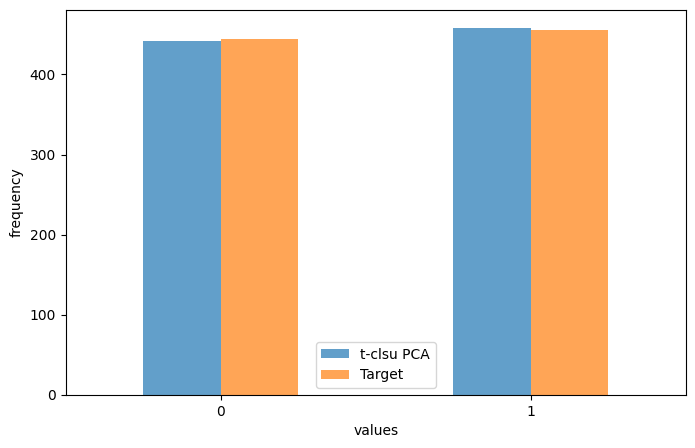

In [1418]:
counts_kmeans = df_pca_trim_kmeans['trim_kmeans_pca'].value_counts().sort_index()
counts_target = df_pca_trim_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'t-clust PCA': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["t-clsu PCA", "Target"])
plt.xticks(rotation=0)  
plt.show()


In [1419]:
print(confusion_matrix(df_pca_trim_kmeans['target'],df_pca_trim_kmeans['trim_kmeans_pca']))

[[442   2]
 [  0 456]]


In [1420]:
print(classification_report(df_pca_trim_kmeans['target'],df_pca_trim_kmeans['trim_kmeans_pca']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      1.00      1.00       456

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



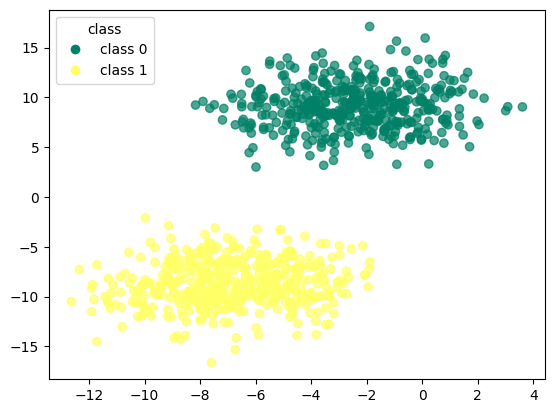

In [1421]:
scatter = plt.scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                      c=df_pca_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

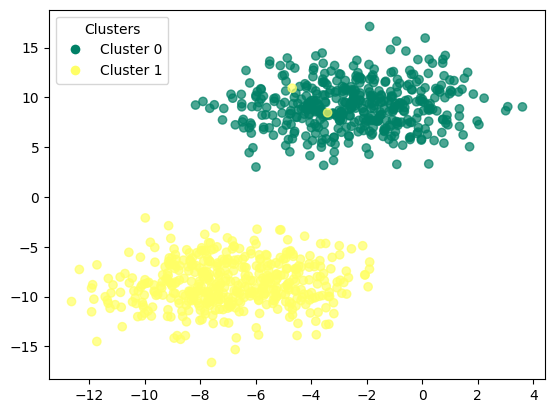

In [1422]:
scatter = plt.scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                      c=df_pca_trim_kmeans['trim_kmeans_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_trim_kmeans['trim_kmeans_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

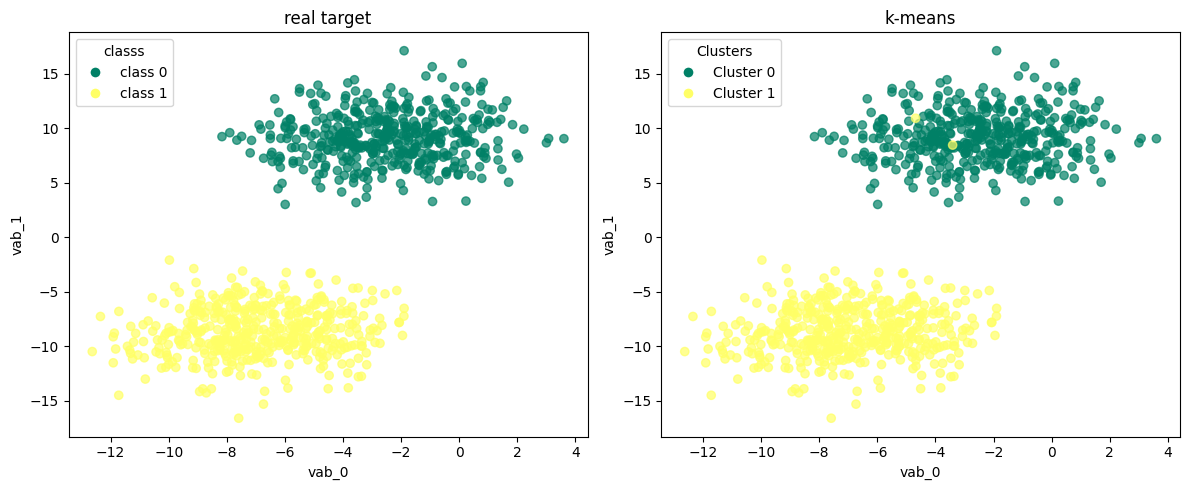

In [1423]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                           c=df_pca_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_trim_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                           c=df_pca_trim_kmeans['trim_kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_trim_kmeans['trim_kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

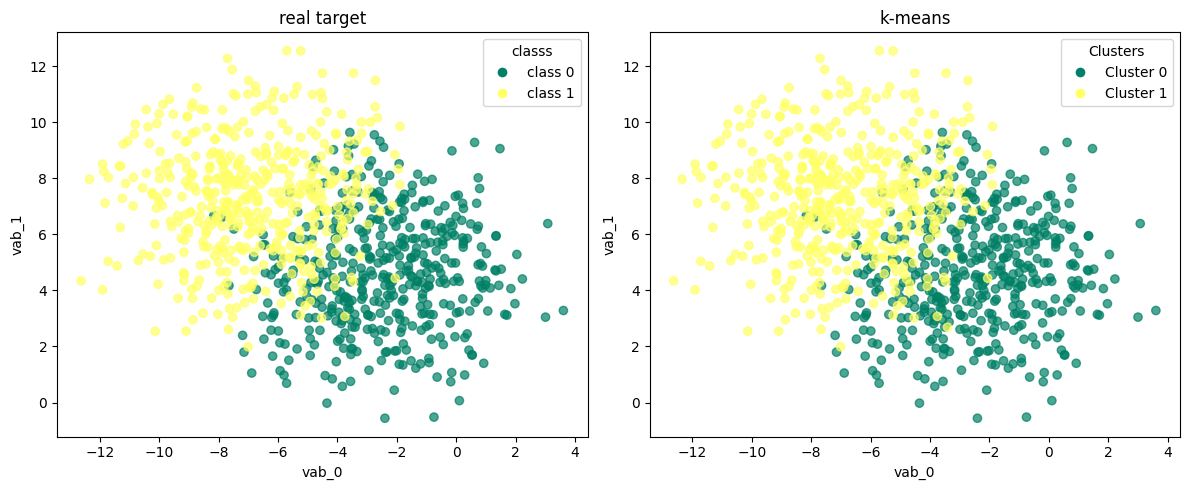

In [1424]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 2], 
                           c=df_pca_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_trim_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 2], 
                           c=df_pca_trim_kmeans['trim_kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_trim_kmeans['trim_kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

### trimmed k-means with t-SNE

In [1425]:
trim_kmeans_tsne,trimmmed_indices = trimmed_clustering(X_tsne,n_clusters=2,trim_fraction=0.1)

In [1426]:
trim_kmeans_tsne

KMeans(n_clusters=2, random_state=42)

In [1427]:
df_tsne_trim_kmeans = corr_dataset.copy()

In [1428]:
df_tsne_trim_kmeans = df_tsne_trim_kmeans.iloc[trimmmed_indces]  

In [1429]:
df_tsne_trim_kmeans['trim_kmeans_tsne'] = trim_kmeans_tsne.labels_

In [1430]:
df_tsne_trim_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  \
0    -3.836390   8.639241  0.577657  0.290482 -5.854879       0   
1    -3.963108  10.911483  6.195401  0.249843 -7.251451       0   
2     0.814275   9.969076  4.959448  1.943864 -5.012513       0   
3    -3.633853   5.001985  9.142150  2.710974 -4.540339       0   
4    -3.953195   5.674644  3.223531 -2.248645 -2.937601       0   
..         ...        ...       ...       ...       ...     ...   
994 -10.010557  -9.847225  7.192476  2.631717  6.903013       1   
995  -6.049769  -4.358451  5.572504  0.473130  2.611179       1   
996  -6.280810  -9.083992  9.528153  3.295749  2.401180       1   
998  -1.893983  -6.530449  9.849472  0.489431  8.373307       1   
999  -3.833880 -12.472677  6.484633  1.103926  6.061338       1   

     trim_kmeans_tsne  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
994                 1  
995                 1  
996                 1  
998                 1  
999                 1  

[900 rows x 7 columns]

In [1431]:
y_true = df_tsne_trim_kmeans['target'].values  
y_kmeans = df_tsne_trim_kmeans['trim_kmeans_tsne'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_tsne_trim_kmeans['trim_kmeans_tsne'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_tsne_trim_kmeans['trim_kmeans_tsne'] == y_true))

accuracy before: 0.9888888888888889
accuracy after: 0.9888888888888889


In [1432]:
df_tsne_trim_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  \
0    -3.836390   8.639241  0.577657  0.290482 -5.854879       0   
1    -3.963108  10.911483  6.195401  0.249843 -7.251451       0   
2     0.814275   9.969076  4.959448  1.943864 -5.012513       0   
3    -3.633853   5.001985  9.142150  2.710974 -4.540339       0   
4    -3.953195   5.674644  3.223531 -2.248645 -2.937601       0   
..         ...        ...       ...       ...       ...     ...   
994 -10.010557  -9.847225  7.192476  2.631717  6.903013       1   
995  -6.049769  -4.358451  5.572504  0.473130  2.611179       1   
996  -6.280810  -9.083992  9.528153  3.295749  2.401180       1   
998  -1.893983  -6.530449  9.849472  0.489431  8.373307       1   
999  -3.833880 -12.472677  6.484633  1.103926  6.061338       1   

     trim_kmeans_tsne  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
994                 1  
995                 1  
996                 1  
998                 1  
999                 1  

[900 rows x 7 columns]

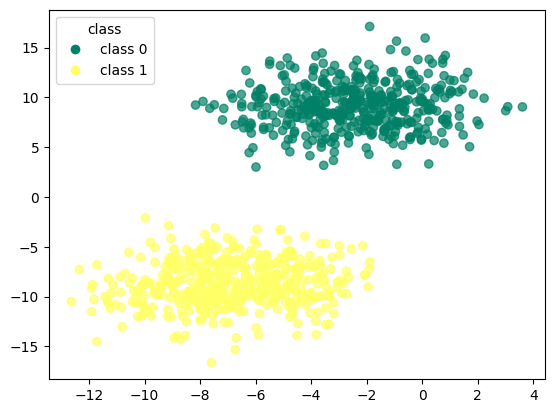

In [1433]:
scatter = plt.scatter(df_tsne_trim_kmeans.iloc[:, 0], df_tsne_trim_kmeans.iloc[:, 1], 
                      c=df_tsne_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

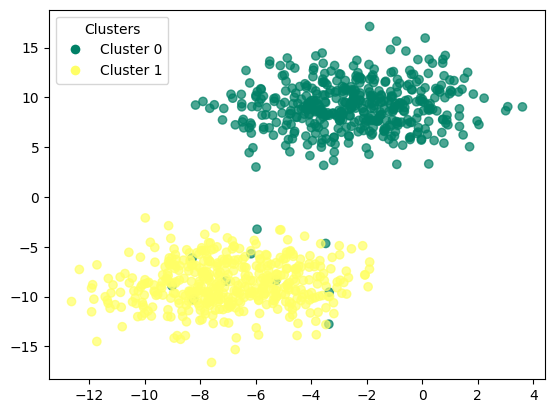

In [1434]:
scatter = plt.scatter(df_tsne_trim_kmeans.iloc[:, 0], df_tsne_trim_kmeans.iloc[:, 1], 
                      c=df_tsne_trim_kmeans['trim_kmeans_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_trim_kmeans['trim_kmeans_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

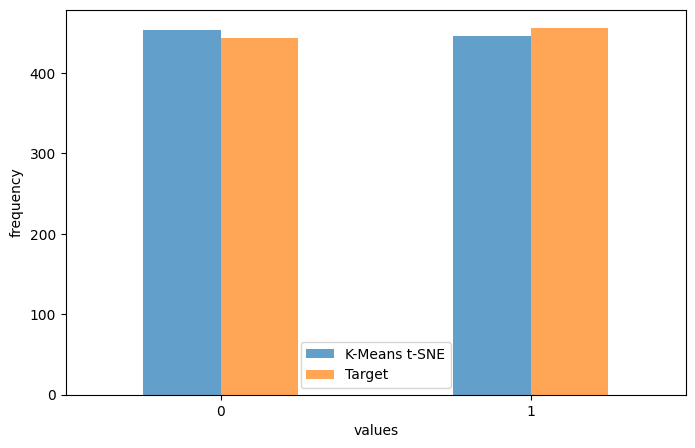

In [1435]:
counts_kmeans = df_tsne_trim_kmeans['trim_kmeans_tsne'].value_counts().sort_index()
counts_target = df_tsne_trim_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means t-SNE': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means t-SNE", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [1436]:
print(confusion_matrix(df_tsne_trim_kmeans['target'],df_tsne_trim_kmeans['trim_kmeans_tsne']))

[[444   0]
 [ 10 446]]


In [1437]:
print(classification_report(df_tsne_trim_kmeans['target'],df_tsne_trim_kmeans['trim_kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       444
           1       1.00      0.98      0.99       456

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



### trimmed k-means with UMAP

In [1438]:
trim_kmeans_UMAP,trimmmed_indices = trimmed_clustering(X_umap,n_clusters=2,trim_fraction=0.1)

In [1439]:
trim_kmeans_UMAP

KMeans(n_clusters=2, random_state=42)

In [1440]:
df_UMAP_trim_kmeans = corr_dataset.copy()

In [1441]:
df_UMAP_trim_kmeans = df_UMAP_trim_kmeans.iloc[trimmmed_indices]

In [1442]:
df_UMAP_trim_kmeans['trim_kmeans_UMAP'] = trim_kmeans_UMAP.labels_

In [1443]:
df_UMAP_trim_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  \
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0   
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0   
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0   
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0   
5   -5.712649   6.780309  4.017178  4.503873 -6.450090       0   
..        ...        ...       ...       ...       ...     ...   
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1   
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1   
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1   
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1   
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1   

     trim_kmeans_UMAP  
0                   0  
1                   0  
2                   0  
3                   0  
5                   0  
..                ...  
995                 1  
996                 1  
997                 1  
998                 1  
999                 1  

[900 rows x 7 columns]

In [1444]:
y_true = df_UMAP_trim_kmeans['target'].values  
y_kmeans = df_UMAP_trim_kmeans['trim_kmeans_UMAP'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_UMAP_trim_kmeans['trim_kmeans_UMAP'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_UMAP_trim_kmeans['trim_kmeans_UMAP'] == y_true))

accuracy before: 1.0
accuracy after: 1.0


In [1445]:
df_UMAP_trim_kmeans

vab_1      vab_2     vab_3     vab_4     vab_5  target  \
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0   
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0   
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0   
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0   
5   -5.712649   6.780309  4.017178  4.503873 -6.450090       0   
..        ...        ...       ...       ...       ...     ...   
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1   
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1   
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1   
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1   
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1   

     trim_kmeans_UMAP  
0                   0  
1                   0  
2                   0  
3                   0  
5                   0  
..                ...  
995                 1  
996                 1  
997                 1  
998                 1  
999                 1  

[900 rows x 7 columns]

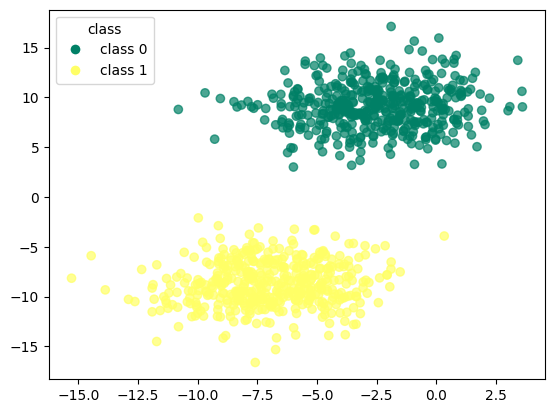

In [1446]:
scatter = plt.scatter(df_UMAP_trim_kmeans.iloc[:, 0], df_UMAP_trim_kmeans.iloc[:, 1], 
                      c=df_UMAP_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_UMAP_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

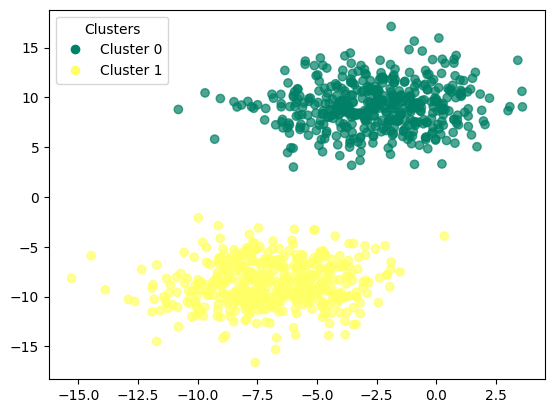

In [1447]:
scatter = plt.scatter(df_UMAP_trim_kmeans.iloc[:, 0], df_UMAP_trim_kmeans.iloc[:, 1], 
                      c=df_UMAP_trim_kmeans['trim_kmeans_UMAP'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_UMAP_trim_kmeans['trim_kmeans_UMAP'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

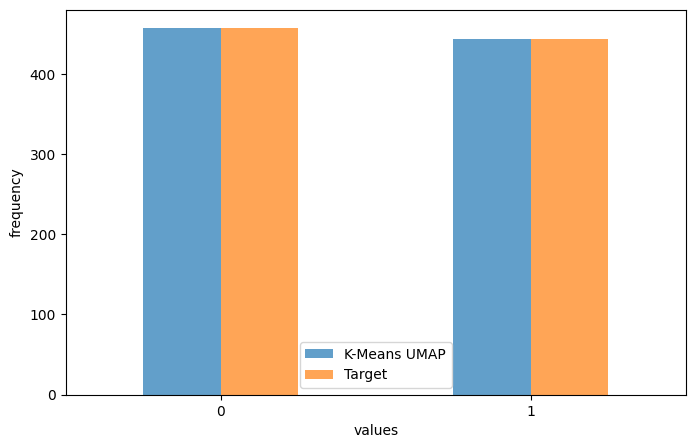

In [1448]:
counts_kmeans = df_UMAP_trim_kmeans['trim_kmeans_UMAP'].value_counts().sort_index()
counts_target = df_UMAP_trim_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means UMAP': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means UMAP", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [1449]:
print(confusion_matrix(df_UMAP_trim_kmeans['target'],df_UMAP_trim_kmeans['trim_kmeans_UMAP']))

[[457   0]
 [  0 443]]


In [1450]:
print(classification_report(df_UMAP_trim_kmeans['target'],df_UMAP_trim_kmeans['trim_kmeans_UMAP'])) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       457
           1       1.00      1.00      1.00       443

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



## dbscan

In [1451]:
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()

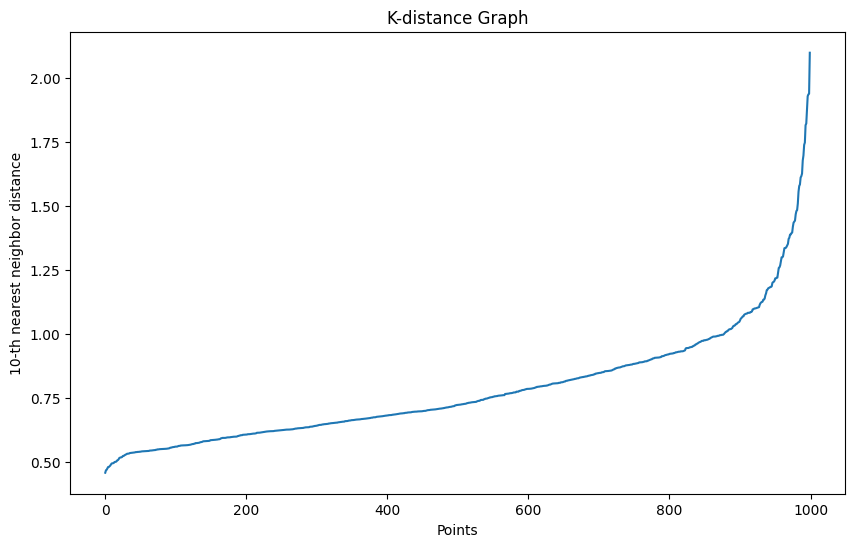

In [1452]:
plot_k_distance_graph(X_values,k=10) 

In [1453]:
dbscan = DBSCAN(eps=1,min_samples=10) # min_samples = 2*n_features

In [1454]:
dbscan.fit(X_values)

DBSCAN(eps=1, min_samples=10)

In [1455]:
df_dbscan = corr_dataset.copy()

In [1456]:
df_dbscan['dbscan'] = dbscan.labels_

In [1457]:
df_dbscan

vab_1      vab_2     vab_3     vab_4     vab_5  target  dbscan
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0       0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0       0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0       0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0       0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0       0
..        ...        ...       ...       ...       ...     ...     ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1       1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1       1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1       1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1       1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1       1

[1000 rows x 7 columns]

In [1458]:
print(df_dbscan['dbscan'].value_counts())

dbscan
 1    489
 0    479
-1     32
Name: count, dtype: int64


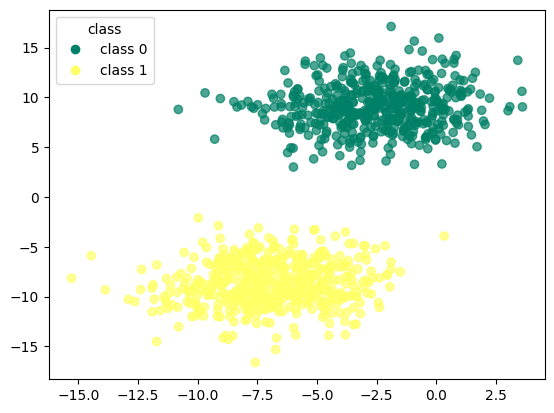

In [1459]:
scatter = plt.scatter(df_dbscan.iloc[:, 0], df_dbscan.iloc[:, 1], 
                      c=df_dbscan['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_dbscan['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

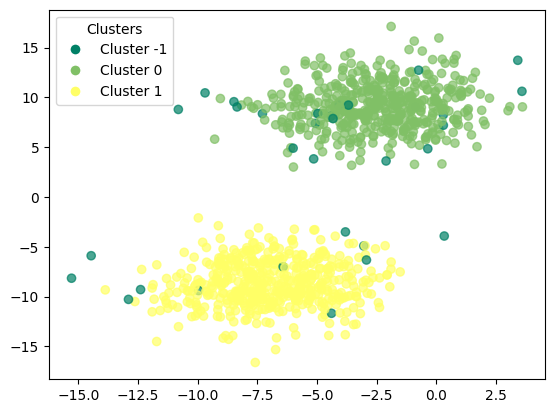

In [1460]:
scatter = plt.scatter(df_dbscan.iloc[:, 0], df_dbscan.iloc[:, 1], 
                      c=df_dbscan['dbscan'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_dbscan['dbscan'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [1461]:
print(confusion_matrix(df_dbscan['target'],df_dbscan['dbscan']))

[[  0   0   0]
 [ 21 479   0]
 [ 11   0 489]]


In [1462]:
print(classification_report(df_dbscan['target'],df_dbscan['dbscan']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      0.96      0.98       500
           1       1.00      0.98      0.99       500

    accuracy                           0.97      1000
   macro avg       0.67      0.65      0.66      1000
weighted avg       1.00      0.97      0.98      1000



### dbscan with pca

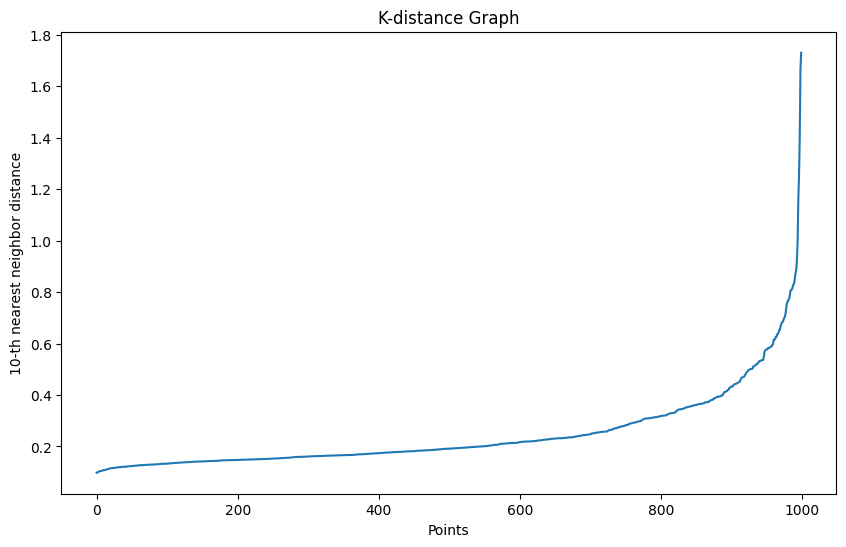

In [1463]:
plot_k_distance_graph(scores_pca,k=10)

In [1464]:
dbscan_pca = DBSCAN(eps=0.5,min_samples=10)

In [1465]:
dbscan_pca.fit(scores_pca)

DBSCAN(min_samples=10)

In [1466]:
df_pca_dbscan = corr_dataset.copy()

In [1467]:
df_pca_dbscan["dbscan_pca"] = dbscan_pca.labels_

In [1468]:
df_pca_dbscan

vab_1      vab_2     vab_3     vab_4     vab_5  target  dbscan_pca
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0           0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0           0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0           0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0           0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0           0
..        ...        ...       ...       ...       ...     ...         ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1           1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1           1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1           1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1           1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1           1

[1000 rows x 7 columns]

In [1469]:
print(df_pca_dbscan['dbscan_pca'].value_counts())

dbscan_pca
 1    494
 0    479
-1     27
Name: count, dtype: int64


In [1470]:
print(confusion_matrix(df_pca_dbscan['target'],df_pca_dbscan['dbscan_pca']))

[[  0   0   0]
 [ 21 479   0]
 [  6   0 494]]


In [1471]:
print(classification_report(df_pca_dbscan['target'],df_pca_dbscan['dbscan_pca']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      0.96      0.98       500
           1       1.00      0.99      0.99       500

    accuracy                           0.97      1000
   macro avg       0.67      0.65      0.66      1000
weighted avg       1.00      0.97      0.99      1000



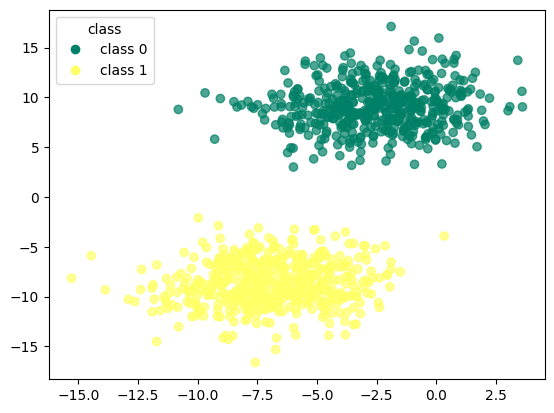

In [1472]:
scatter = plt.scatter(df_pca_dbscan.iloc[:, 0], df_pca_dbscan.iloc[:, 1], 
                      c=df_pca_dbscan['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_dbscan['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

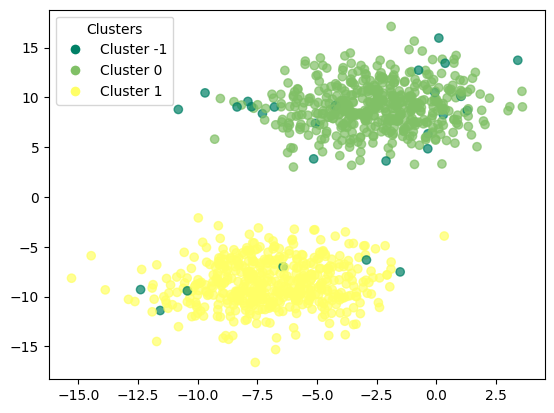

In [1473]:
scatter = plt.scatter(df_pca_dbscan.iloc[:, 0], df_pca_dbscan.iloc[:, 1], 
                      c=df_pca_dbscan['dbscan_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_dbscan['dbscan_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### dbscan with t-SNE

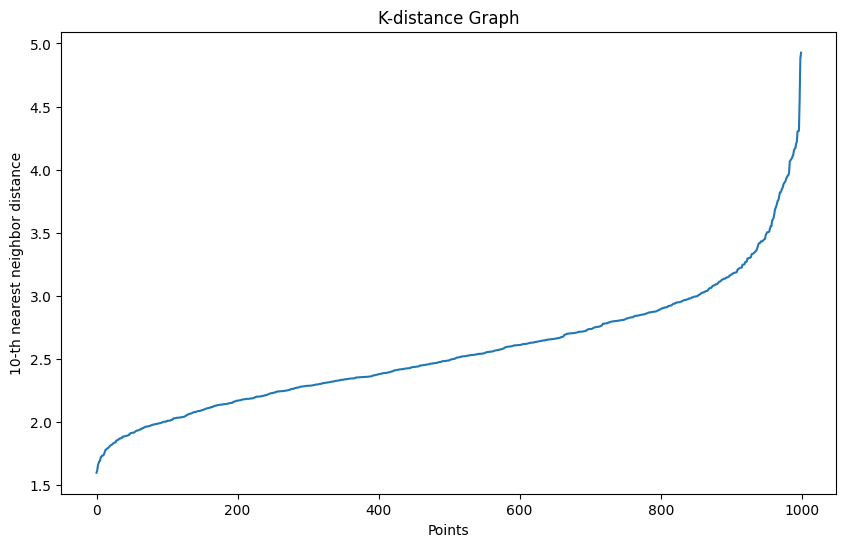

In [1474]:
plot_k_distance_graph(X_tsne,k=10)

In [1475]:
dbscan_tsne = DBSCAN(eps=3,min_samples=10)

In [1476]:
dbscan_tsne.fit(X_tsne)

DBSCAN(eps=3, min_samples=10)

In [1477]:
df_tsne_dbscan = corr_dataset.copy()

In [1478]:
df_tsne_dbscan['dbscan_tsne'] = dbscan_tsne.labels_

In [1479]:
df_tsne_dbscan

vab_1      vab_2     vab_3     vab_4     vab_5  target  dbscan_tsne
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0            0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0            0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0            0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0           -1
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0            0
..        ...        ...       ...       ...       ...     ...          ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1            1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1            1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1            1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1            1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1            1

[1000 rows x 7 columns]

In [1480]:
print(df_tsne_dbscan['dbscan_tsne'].value_counts())

dbscan_tsne
 0    498
 1    492
-1     10
Name: count, dtype: int64


In [1481]:
print(confusion_matrix(df_tsne_dbscan['target'],df_tsne_dbscan['dbscan_tsne']))

[[  0   0   0]
 [  2 498   0]
 [  8   0 492]]


In [1482]:
print(classification_report(df_tsne_dbscan['target'],df_tsne_dbscan['dbscan_tsne']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      1.00      1.00       500
           1       1.00      0.98      0.99       500

    accuracy                           0.99      1000
   macro avg       0.67      0.66      0.66      1000
weighted avg       1.00      0.99      0.99      1000



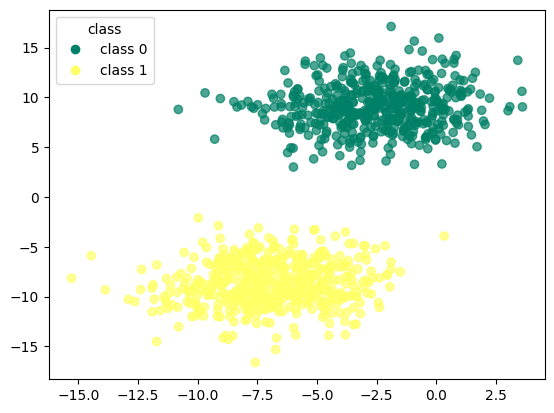

In [1483]:
scatter = plt.scatter(df_tsne_dbscan.iloc[:, 0], df_tsne_dbscan.iloc[:, 1], 
                      c=df_tsne_dbscan['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_dbscan['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

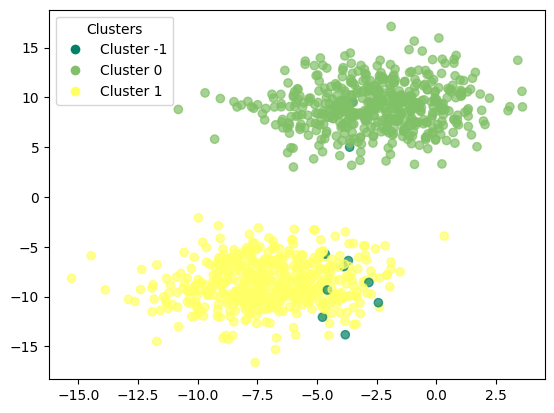

In [1484]:
scatter = plt.scatter(df_tsne_dbscan.iloc[:, 0], df_tsne_dbscan.iloc[:, 1], 
                      c=df_tsne_dbscan['dbscan_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_dbscan['dbscan_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### dbscan with UMAP

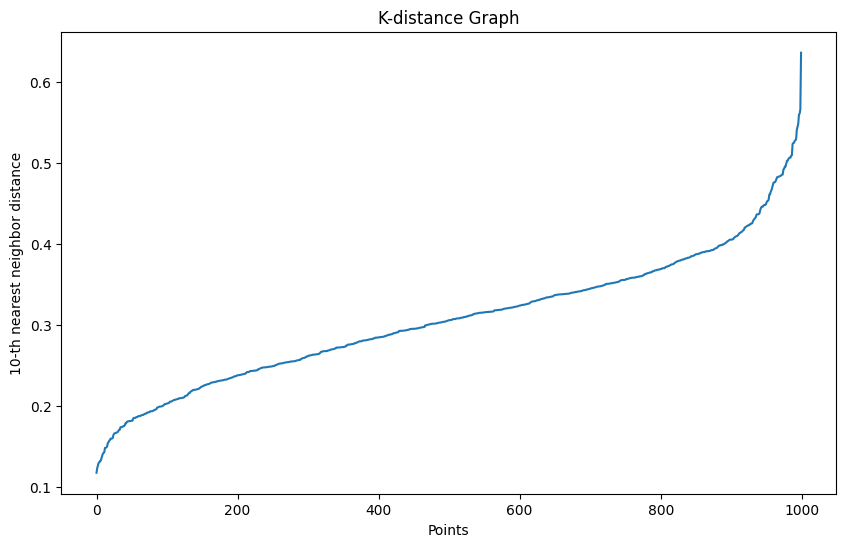

In [1485]:
plot_k_distance_graph(X_umap,k=10)

In [1486]:
dbscan_UMAP = DBSCAN(eps=0.5,min_samples=10)

In [1487]:
dbscan_UMAP.fit(X_umap)

DBSCAN(min_samples=10)

In [1488]:
df_UMAP_dbscan = corr_dataset.copy()

In [1489]:
df_UMAP_dbscan['dbscan_UMAP'] = dbscan_UMAP.labels_

In [1490]:
df_UMAP_dbscan

vab_1      vab_2     vab_3     vab_4     vab_5  target  dbscan_UMAP
0   -3.836390   8.639241  0.577657  0.290482 -5.854879       0            0
1   -3.963108  10.911483  6.195401  0.249843 -7.251451       0            0
2    0.814275   9.969076  4.959448  1.943864 -5.012513       0            0
3   -3.633853   5.001985  9.142150  2.710974 -4.540339       0            0
4   -3.953195   5.674644  3.223531 -2.248645 -2.937601       0            0
..        ...        ...       ...       ...       ...     ...          ...
995 -6.049769  -4.358451  5.572504  0.473130  2.611179       1            1
996 -6.280810  -9.083992  9.528153  3.295749  2.401180       1            1
997 -9.138302 -10.813423  3.270044 -1.043372  0.062889       1            1
998 -1.893983  -6.530449  9.849472  0.489431  8.373307       1            1
999 -3.833880 -12.472677  6.484633  1.103926  6.061338       1            1

[1000 rows x 7 columns]

In [1491]:
print(df_UMAP_dbscan['dbscan_UMAP'].value_counts())

dbscan_UMAP
0    500
1    500
Name: count, dtype: int64


In [1492]:
print(confusion_matrix(df_UMAP_dbscan['target'],df_UMAP_dbscan['dbscan_UMAP']))

[[500   0]
 [  0 500]]


In [1493]:
print(classification_report(df_UMAP_dbscan['target'],df_UMAP_dbscan['dbscan_UMAP']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



# overall results k-means

In [1494]:
print(classification_report(df_kmeans['target'],df_kmeans['k_means']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [1495]:
print(classification_report(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [1496]:
print(classification_report(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [1497]:
print(classification_report(df_UMAP_kmeans['target'],df_UMAP_kmeans['kmeans_UMAP'])) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



# overall results trimmed k-means

In [1498]:
print(classification_report(df_trim_kmeans['target'],df_trim_kmeans['trim_kmeans']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      1.00      1.00       456

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [1499]:
print(classification_report(df_pca_trim_kmeans['target'],df_pca_trim_kmeans['trim_kmeans_pca']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      1.00      1.00       456

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [1500]:
print(classification_report(df_tsne_trim_kmeans['target'],df_tsne_trim_kmeans['trim_kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       444
           1       1.00      0.98      0.99       456

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



In [1501]:
print(classification_report(df_UMAP_trim_kmeans['target'],df_UMAP_trim_kmeans['trim_kmeans_UMAP'])) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       457
           1       1.00      1.00      1.00       443

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



# overall results dbscan

In [1502]:
print(classification_report(df_dbscan['target'],df_dbscan['dbscan']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      0.96      0.98       500
           1       1.00      0.98      0.99       500

    accuracy                           0.97      1000
   macro avg       0.67      0.65      0.66      1000
weighted avg       1.00      0.97      0.98      1000



In [1503]:
print(classification_report(df_pca_dbscan['target'],df_pca_dbscan['dbscan_pca']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      0.96      0.98       500
           1       1.00      0.99      0.99       500

    accuracy                           0.97      1000
   macro avg       0.67      0.65      0.66      1000
weighted avg       1.00      0.97      0.99      1000



In [1504]:
print(classification_report(df_tsne_dbscan['target'],df_tsne_dbscan['dbscan_tsne']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      1.00      1.00       500
           1       1.00      0.98      0.99       500

    accuracy                           0.99      1000
   macro avg       0.67      0.66      0.66      1000
weighted avg       1.00      0.99      0.99      1000



In [1505]:
print(classification_report(df_UMAP_dbscan['target'],df_UMAP_dbscan['dbscan_UMAP']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

